In [200]:
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
import seaborn as sns
import streamlit as st
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller,kpss
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go


sns.set_style('whitegrid')

# machine learning stack
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# time-related stack
from datetime import datetime as dt

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

In [16]:
def qcd_variance(series,window=365):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    print("Vars = " , variances)
    # first" quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion for currency {qcd}")

In [5]:
daily_gold_rate = pd.read_csv('data/daily_gold_rate.csv', sep=';')

In [6]:
daily_gold_rate.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1/1/1985,308.30,402.45,266.01,3825.85,1134.42,NaN
1,1/2/1985,305.50,401.49,266.00,3787.05,1134.42,NaN
2,1/3/1985,302.30,397.08,262.76,3718.88,1107.67,NaN
3,1/4/1985,303.15,397.15,262.58,3759.64,1118.21,NaN
4,1/7/1985,298.25,392.55,261.17,3741.23,1091.58,835.8


In [7]:
daily_gold_rate.describe()

,USD,EUR,GBP,INR,AED,CNY
count,10114.000000,10114.000000,10114.000000,10114.000000,10114.000000,10110.000000
mean,799.552704,669.997853,540.951871,43928.065703,2936.556642,5307.108772
std,544.858424,463.177911,418.160576,43583.244790,2001.379712,3659.619165
min,252.800000,222.200000,156.890000,3687.170000,928.480000,809.630000
25%,356.612500,307.290000,221.532500,11748.690000,1310.965000,2220.950000
50%,440.525000,375.070000,265.350000,18305.155000,1617.855000,3376.265000
75%,1270.450000,1063.837500,884.762500,79378.062500,4666.365000,8326.245000
max,2067.150000,1863.680000,1634.970000,167324.360000,7592.640000,14373.930000


## Converting date field and setting it as index

In [9]:
daily_gold_rate['Date'] = pd.to_datetime(daily_gold_rate['Date'])
daily_gold_rate.set_index(daily_gold_rate['Date'],inplace=True)
daily_gold_rate.drop(columns=['Date'], inplace=True)

In [10]:
daily_gold_rate

,USD,EUR,GBP,INR,AED,CNY
Date,,,,,,
1985-01-01,308.30,402.45,266.01,3825.85,1134.42,NaN
1985-01-02,305.50,401.49,266.00,3787.05,1134.42,NaN
1985-01-03,302.30,397.08,262.76,3718.88,1107.67,NaN
1985-01-04,303.15,397.15,262.58,3759.64,1118.21,NaN
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80
...,...,...,...,...,...,...
2023-10-02,1833.05,1747.59,1513.92,152333.60,6732.79,13377.60
2023-10-03,1822.45,1741.97,1509.28,151684.52,6693.86,13300.24
2023-10-04,1818.95,1730.36,1496.83,151375.75,6680.82,13274.70


In [11]:
daily_gold_rate.isna().sum()

USD    0
EUR    0
GBP    0
INR    0
AED    0
CNY    4
dtype: int64

In [12]:
daily_gold_rate = daily_gold_rate.dropna()

In [131]:
daily_gold_rate

,USD,EUR,GBP,INR,AED,CNY
Date,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69
...,...,...,...,...,...,...
2023-10-02,1833.05,1747.59,1513.92,152333.60,6732.79,13377.60
2023-10-03,1822.45,1741.97,1509.28,151684.52,6693.86,13300.24
2023-10-04,1818.95,1730.36,1496.83,151375.75,6680.82,13274.70


In [132]:
daily_gold_rate.info()
daily_gold_rate.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10110 entries, 1985-01-07 to 2023-10-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD     10110 non-null  float64
 1   EUR     10110 non-null  float64
 2   GBP     10110 non-null  float64
 3   INR     10110 non-null  float64
 4   AED     10110 non-null  float64
 5   CNY     10110 non-null  float64
dtypes: float64(6)
memory usage: 552.9 KB


,USD,EUR,GBP,INR,AED,CNY
Date,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69


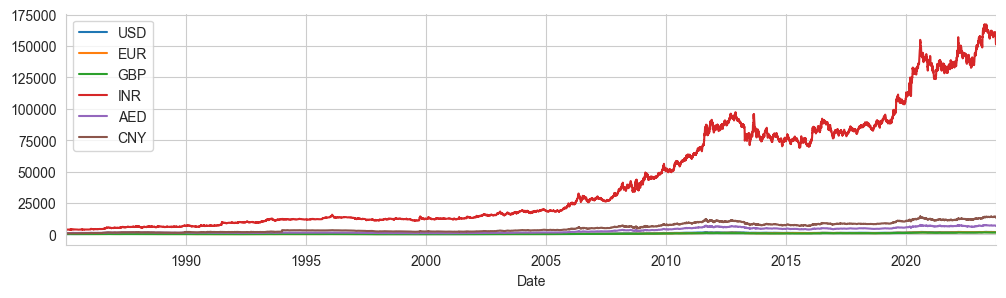

In [211]:
mpl.rc('figure',figsize=(12,3),dpi=100)
daily_gold_rate['USD'].plot(legend=True)
daily_gold_rate['EUR'].plot(legend=True)
daily_gold_rate['GBP'].plot(legend=True)
daily_gold_rate['INR'].plot(legend=True)
daily_gold_rate['AED'].plot(legend=True)
daily_gold_rate['CNY'].plot(legend=True)


sns.despine()

In [19]:
qcd_variance(daily_gold_rate['USD'])
#qcd_variance(daily_gold_rate['EUR'])
#qcd_variance(daily_gold_rate['GBP'])
#qcd_variance(daily_gold_rate['INR'])
#qcd_variance(daily_gold_rate['AED'])
#qcd_variance(daily_gold_rate['CNY'])


Vars =  Date
1986-05-30      235.808458
1986-06-02      234.625456
1986-06-03      233.962153
1986-06-04      232.947451
1986-06-05      232.416705
                  ...     
2023-10-02    11286.103077
2023-10-03    11287.794857
2023-10-04    11290.184538
2023-10-05    11292.148595
2023-10-06    11290.690216
Name: USD, Length: 9746, dtype: float64
quartile coefficient of dispersion for currency 0.898996


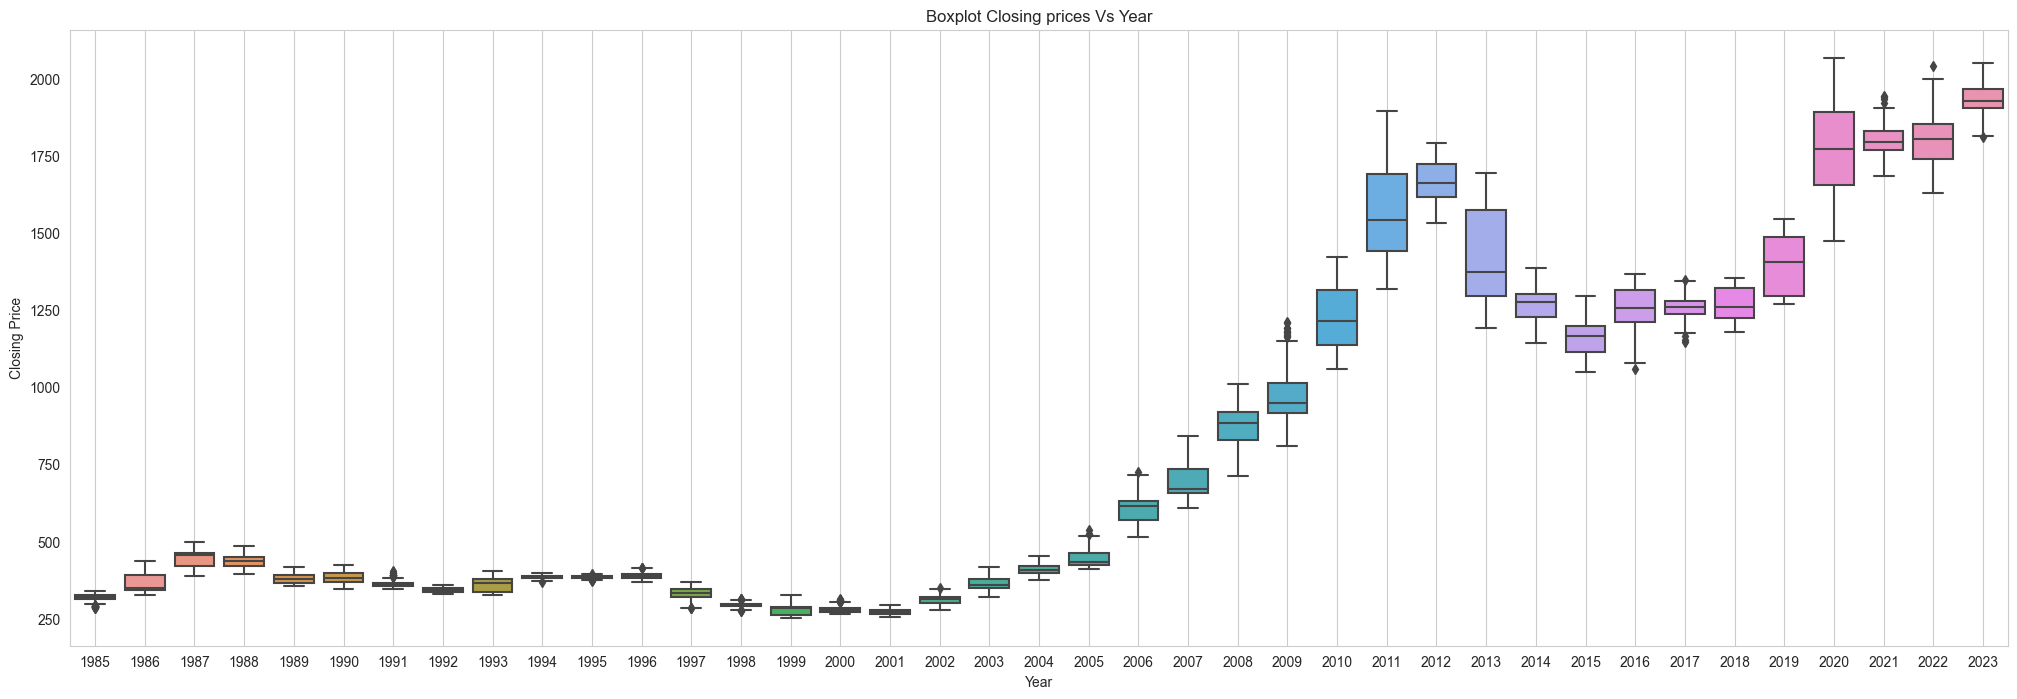

In [20]:
_, ax=plt.subplots(figsize=(25,8))
sns.boxplot(x=daily_gold_rate.index.year, y=daily_gold_rate.values[:,0],ax=ax)
plt.title('Boxplot Closing prices Vs Year')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.grid()

## Log Transformation (The data at first did not make sense)

In [21]:
daily_gold_rate['log_USD'] = np.log(daily_gold_rate['USD'])
daily_gold_rate['log_EUR'] = np.log(daily_gold_rate['EUR'])
daily_gold_rate['log_GBP'] = np.log(daily_gold_rate['GBP'])
daily_gold_rate['log_INR'] = np.log(daily_gold_rate['INR'])
daily_gold_rate['log_AED'] = np.log(daily_gold_rate['AED'])
daily_gold_rate['log_CNY'] = np.log(daily_gold_rate['CNY'])

daily_gold_rate.head()

,USD,EUR,GBP,INR,AED,CNY,log_USD,log_EUR,log_GBP,log_INR,log_AED,log_CNY
Date,,,,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,5.697932,5.972664,5.565172,8.227170,6.995381,6.728389
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,5.710427,5.979696,5.572420,8.248189,7.015766,6.748771
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,5.705448,5.975183,5.572686,8.227437,7.000763,6.733771
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,5.716370,5.985522,5.591062,8.256709,7.027164,6.760171
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,5.717850,5.987958,5.600531,8.254677,7.035137,6.768137


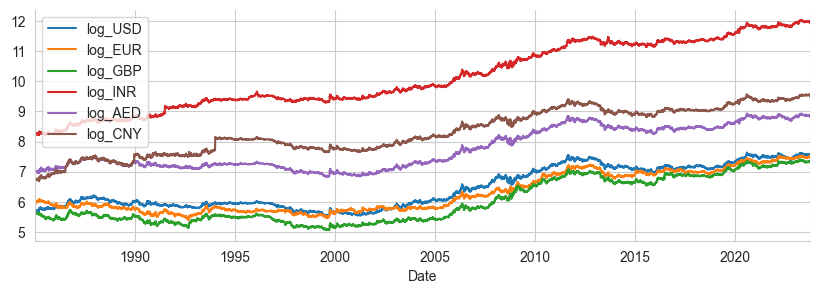

In [22]:
mpl.rc('figure',figsize=(10,3),dpi=100)

daily_gold_rate['log_USD'].plot(legend=True)
daily_gold_rate['log_EUR'].plot(legend=True)
daily_gold_rate['log_GBP'].plot(legend=True)
daily_gold_rate['log_INR'].plot(legend=True)
daily_gold_rate['log_AED'].plot(legend=True)
daily_gold_rate['log_CNY'].plot(legend=True)

sns.despine()

In [23]:
qcd_variance(daily_gold_rate['log_USD'])
qcd_variance(daily_gold_rate['log_EUR'])
qcd_variance(daily_gold_rate['log_GBP'])
qcd_variance(daily_gold_rate['log_INR'])
qcd_variance(daily_gold_rate['log_AED'])
qcd_variance(daily_gold_rate['log_CNY'])


Vars =  Date
1986-05-30    0.002274
1986-06-02    0.002261
1986-06-03    0.002254
1986-06-04    0.002244
1986-06-05    0.002239
                ...   
2023-10-02    0.003376
2023-10-03    0.003376
2023-10-04    0.003377
2023-10-05    0.003377
2023-10-06    0.003377
Name: log_USD, Length: 9746, dtype: float64
quartile coefficient of dispersion for currency 0.587605
Vars =  Date
1986-05-30    0.006288
1986-06-02    0.006302
1986-06-03    0.006323
1986-06-04    0.006347
1986-06-05    0.006376
                ...   
2023-10-02    0.000748
2023-10-03    0.000748
2023-10-04    0.000748
2023-10-05    0.000748
2023-10-06    0.000749
Name: log_EUR, Length: 9746, dtype: float64
quartile coefficient of dispersion for currency 0.615933
Vars =  Date
1986-05-30    0.004677
1986-06-02    0.004665
1986-06-03    0.004653
1986-06-04    0.004639
1986-06-05    0.004618
                ...   
2023-10-02    0.001066
2023-10-03    0.001066
2023-10-04    0.001067
2023-10-05    0.001067
2023-10-06    0.001067


## Trying seasonal decomposition to see how logarithmic version behaves


In [166]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

<Figure size 1000x700 with 0 Axes>

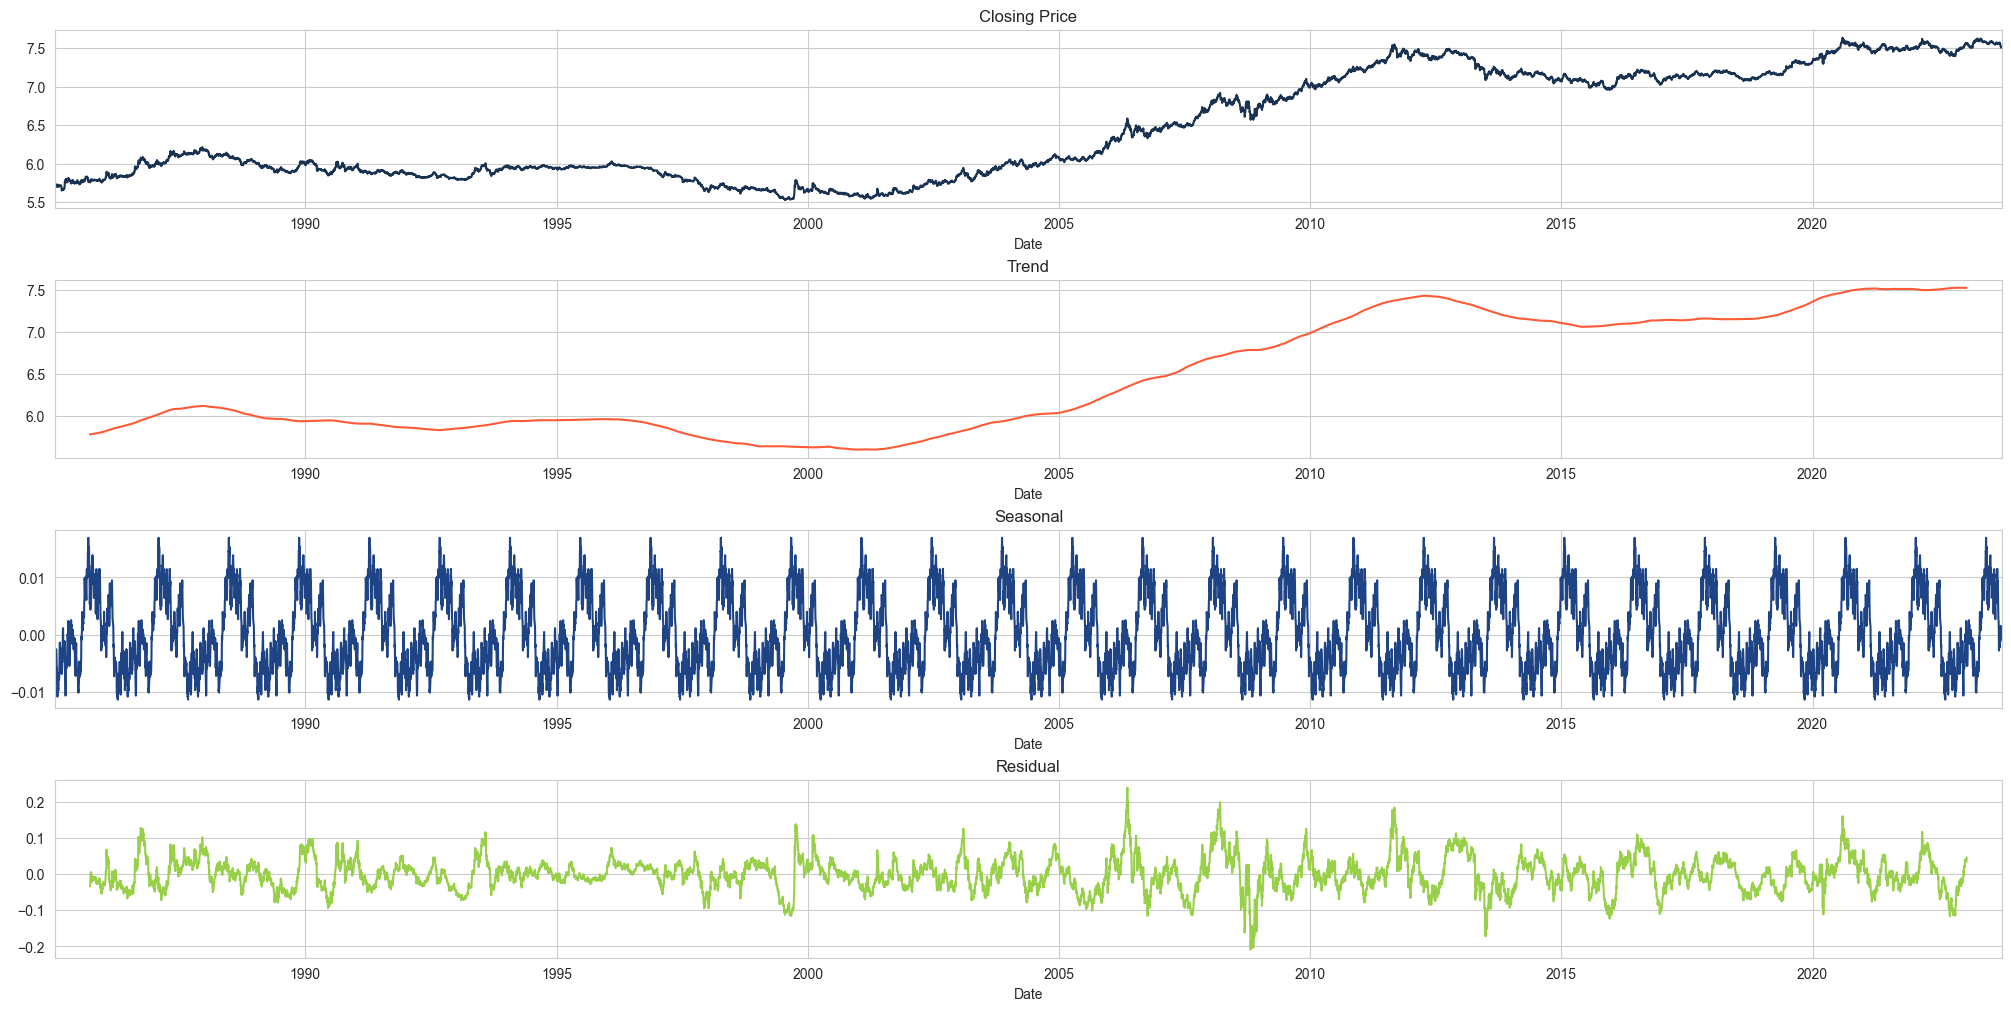

In [168]:
decomposition_USD = seasonal_decompose(daily_gold_rate['log_USD'], model='additive', period=365)

trend = np.exp(decomposition_USD.trend)
seasonal = np.exp(decomposition_USD.seasonal)
residual = np.exp(decomposition_USD.resid)

# Reconstruct the original series (without noise)
reconstructed = trend * seasonal * residual

# Compare the reconstructed series to the original
plt.figure(figsize=(10,7))

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition_USD.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Closing Price')
decomposition_USD.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='Trend')
decomposition_USD.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='Seasonal')
decomposition_USD.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='Residual')
fig.set_size_inches(20, 10);


decomposition_EUR = seasonal_decompose(daily_gold_rate['log_EUR'], model='additive', period=365)
decomposition_GBP = seasonal_decompose(daily_gold_rate['log_GBP'], model='additive', period=365)
decomposition_INR = seasonal_decompose(daily_gold_rate['log_INR'], model='additive', period=365)
decomposition_AED = seasonal_decompose(daily_gold_rate['log_AED'], model='additive', period=365)
decomposition_CNY = seasonal_decompose(daily_gold_rate['log_CNY'], model='additive', period=365)


# Train-Test Split

In [243]:
# Check for stationary first
def stationarity_test(gold_price):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = gold_price.rolling(365).mean()
    rolling_std_dev = gold_price.rolling(365).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(gold_price, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(gold_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
  

In [244]:
stationarity_test(daily_gold_rate['USD'])

KeyError: 'USD'

## Calculating adfuller value for each currency to see the stationarity for each of them

In [242]:
daily_gold_rate=daily_gold_rate[['log_USD' , 'log_EUR' , 'log_GBP','log_INR', 'log_CNY']].dropna()
index=daily_gold_rate.index
columns = daily_gold_rate.columns
df_stats = pd.DataFrame(columns=['P-value'], index=columns)
for col in columns:
  dftest = adfuller(daily_gold_rate[col], autolag='AIC')
  df_stats.loc[col]=dftest[1]

In [239]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Bar(
            x=df_stats.index, y=df_stats['P-value'],
            text=df_stats['P-value'],
            textposition='auto',)])

fig.show()

In [224]:
train = daily_gold_rate.loc[daily_gold_rate.index< '2022-01-01'] 
test = daily_gold_rate.loc[daily_gold_rate.index >= '2022-01-01']

#train = daily_gold_rate[:int(0.8 * len(daily_gold_rate['log_USD']))]
#print(train.log_USD)
#test = daily_gold_rate[int(0.8 * len(daily_gold_rate['log_USD'])):]
train.shape

#X_train, X_test = X.loc[X.index < '2022-01-01'], X.loc[X.index >= '2022-01-01']
#y_train, y_test = y.loc[y.index < '2022-01-01'], y.loc[y.index >= '2022-01-01']




(9650, 21)

In [225]:
test.shape

(460, 21)

In [226]:

train['timestep'] = list(range(train.shape[0]))
#print(train.timestep)


In [227]:
X_trend = train[['timestep']]
y_trend = train['log_USD']
#y_trend

## First Basic Modeling - Polynomial - Linear Regression

In [228]:
trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

print(train.log_USD)

trend_model.fit(X_trend,y_trend)
train['trend'] = trend_model.predict(X_trend)

Date
1985-01-07    5.697932
1985-01-08    5.710427
1985-01-09    5.705448
1985-01-10    5.716370
1985-01-11    5.717850
                ...   
2021-12-27    7.498427
2021-12-28    7.498427
2021-12-29    7.492342
2021-12-30    7.498787
2021-12-31    7.498787
Name: log_USD, Length: 9650, dtype: float64


In [ ]:
mpl.rc('figure',figsize=(12,3),dpi=100)
#print(train.log_USD)
#print(y_trend)
train.log_USD.plot(legend=True)
train['trend'].plot(legend=True)
sns.despine()

## 2nd Basic Modeling with RandomForestRegressor

In [203]:
# How many lags ????
lags_to_fill = pd.DataFrame()
for i in range(10,0,-1):
    lags_to_fill['t-'+str(i)] = daily_gold_rate['log_USD'].shift(i)
    lags_to_fill['t'] = daily_gold_rate['log_USD'].values

lags_to_fill = lags_to_fill.dropna()
lags_to_fill


,t-10,t,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
Date,,,,,,,,,,,
1985-01-21,5.697932,5.727662,5.710427,5.705448,5.716370,5.717850,5.700444,5.709765,5.712742,5.721950,5.730100
1985-01-22,5.710427,5.726522,5.705448,5.716370,5.717850,5.700444,5.709765,5.712742,5.721950,5.730100,5.727662
1985-01-23,5.705448,5.704615,5.716370,5.717850,5.700444,5.709765,5.712742,5.721950,5.730100,5.727662,5.726522
1985-01-24,5.716370,5.706612,5.717850,5.700444,5.709765,5.712742,5.721950,5.730100,5.727662,5.726522,5.704615
1985-01-25,5.717850,5.699942,5.700444,5.709765,5.712742,5.721950,5.730100,5.727662,5.726522,5.704615,5.706612
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,7.561902,7.513737,7.567811,7.572169,7.557473,7.563901,7.562603,7.553313,7.542903,7.535590,7.533961
2023-10-03,7.567811,7.507937,7.572169,7.557473,7.563901,7.562603,7.553313,7.542903,7.535590,7.533961,7.513737
2023-10-04,7.572169,7.506015,7.557473,7.563901,7.562603,7.553313,7.542903,7.535590,7.533961,7.513737,7.507937


## Choosing X and y as lagged and the current values of the Gold Prices for USD Currency


In [247]:

array = lags_to_fill.values
X = array[:, 0:-1]
y = array[:, -1]

X = lags_to_fill.iloc[:,1:]
y=lags_to_fill.iloc[:,0]

X_train, X_test = X.loc[X.index < '2022-01-01'], X.loc[X.index >= '2022-01-01']
y_train, y_test = y.loc[y.index < '2022-01-01'], y.loc[y.index >= '2022-01-01']

rf_model = RandomForestRegressor(n_estimators=9, max_depth =5, random_state=42)
rf_model.fit(X_train, y_train)
pred=rf_model.predict(X_test)
mean_absolute_error(y_test, pred)
pred=pd.Series(pred, index=y_test.index)




In [222]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test.values, mode='lines', name='USD'))
fig.add_trace(go.Scatter(x=pred.index, y=pred.values, mode='lines', name='USD - Forecasting'))

## Deciding on which lags might have the bigger impact on the current USD Rate

In [211]:
import plotly.graph_objects as go
names = lags_to_fill.columns
fig = go.Figure(data=[go.Bar(
            x=lags_to_fill.columns, y=rf_model.feature_importances_,
            text=rf_model.feature_importances_,
            textposition='auto',)])

fig.show()

In [245]:
train.to_csv('data/gold_rate_train.csv')
test.to_csv('data/gold_rate_test.csv')

In [202]:
train['detrended'] = train['log_USD'] - train['trend']

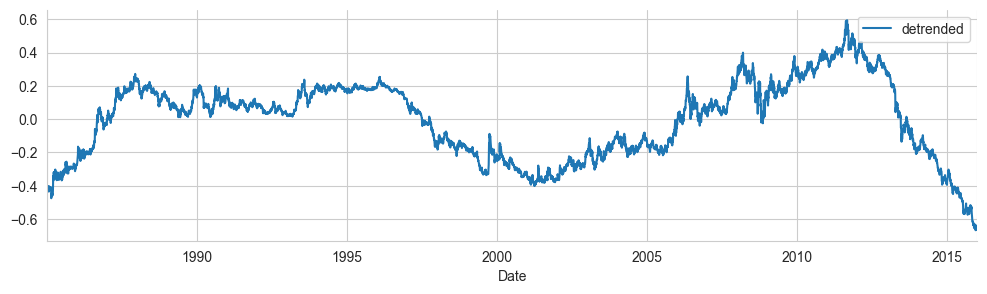

In [203]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended'].plot(legend=True)
sns.despine()

In [208]:
train['month'] = train.index.month
train

,USD,EUR,GBP,INR,AED,CNY,log_USD,log_EUR,log_GBP,log_INR,log_AED,log_CNY,timestep,time_index,trend,detrended,month
Date,,,,,,,,,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,5.697932,5.972664,5.565172,8.227170,6.995381,6.728389,0,0,6.134868,-0.436936,1
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,5.710427,5.979696,5.572420,8.248189,7.015766,6.748771,1,1,6.134571,-0.424144,1
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,5.705448,5.975183,5.572686,8.227437,7.000763,6.733771,2,2,6.134273,-0.428826,1
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,5.716370,5.985522,5.591062,8.256709,7.027164,6.760171,3,3,6.133976,-0.417607,1
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,5.717850,5.987958,5.600531,8.254677,7.035137,6.768137,4,4,6.133679,-0.415830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31,1060.00,971.50,714.96,70437.53,3893.38,6881.52,6.966024,6.878841,6.572227,11.162481,8.267033,8.836595,8083,8083,7.629394,-0.663370,12
2016-01-01,1060.00,971.50,714.96,70437.53,3893.38,6881.52,6.966024,6.878841,6.572227,11.162481,8.267033,8.836595,8084,8084,7.630062,-0.664037,1
2016-01-04,1082.25,1000.42,736.37,72052.63,3975.10,7068.50,6.986797,6.908175,6.601733,11.185152,8.287805,8.863404,8085,8085,7.630729,-0.643931,1


In [64]:
X_seasonality = train[['month']]
y_seasonality = train['detrended']

In [65]:
seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [66]:
seasonality_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [67]:
train['seasonality'] = seasonality_model.predict(X_seasonality)

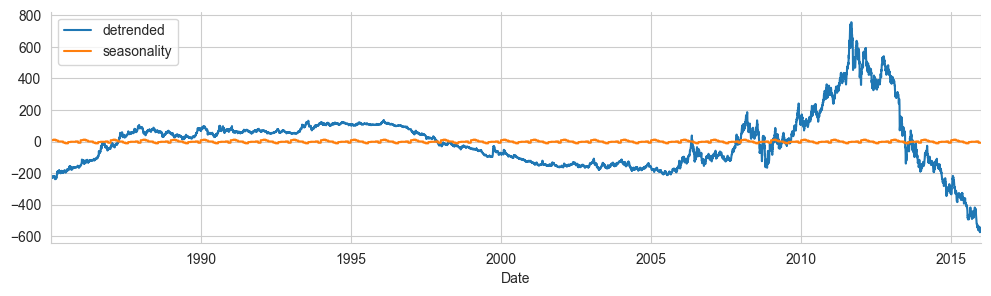

In [68]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended','seasonality']].plot(legend=True)
sns.despine()

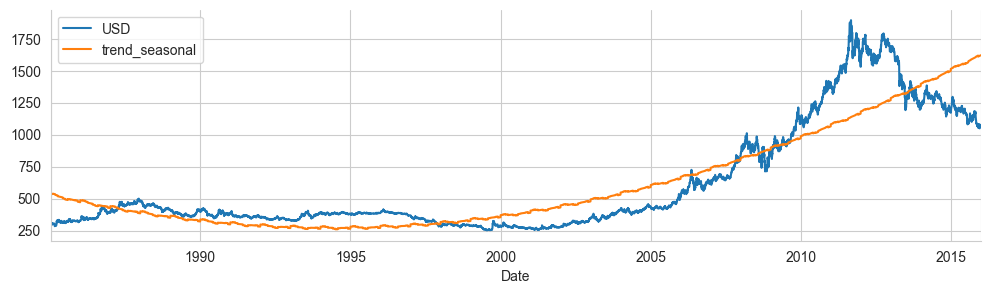

In [69]:
train['trend_seasonal'] = train['trend'] + train['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['USD','trend_seasonal']].plot(legend=True)
sns.despine()

In [70]:
train['remainder'] = train['USD'] - train['trend_seasonal']

In [1]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

NameError: name 'mpl' is not defined

In [72]:
qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.877584


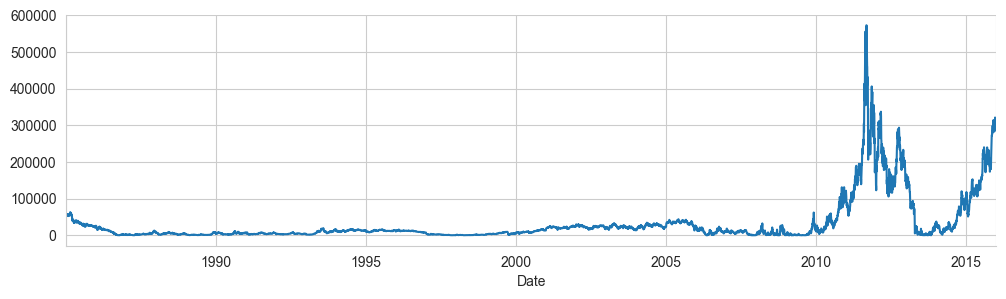

In [73]:
mpl.rc('figure',figsize=(12,3),dpi=100)
(train['remainder']**2).plot()
sns.despine()

In [74]:
qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.877584


In [75]:
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend,detrended,month,seasonality,trend_seasonal,remainder
Date,,,,,,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,1985,0,530.237229,-231.987229,1,8.859847,539.097076,-240.847076
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504,-228.026504,1,8.859847,538.886352,-236.886352
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866,-229.315866,1,8.859847,538.675713,-238.175713
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313,-225.805313,1,8.859847,538.465160,-234.665160
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846,-225.144846,1,8.859847,538.254693,-234.004693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099,-558.267099,12,-7.456732,1619.060367,-550.810367
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299,-558.749299,12,-7.456732,1619.542567,-551.292567
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585,-557.381585,12,-7.456732,1620.024853,-549.924853


In [76]:
def create_lagged_features(df, number_of_lags):
    """"""
    df = df[['remainder']]
    
    lags = list(range(1, number_of_lags+1))
    
    for lag in lags:
        column_name = 'lag_' + str(lag)
        df[column_name] = df['remainder'].shift(lag)
        
    return df

In [77]:
p = 3

In [78]:
df = create_lagged_features(train, p)

In [79]:
df.head()

,remainder,lag_1,lag_2,lag_3
Date,,,,
1985-01-07,-240.847076,NaN,NaN,NaN
1985-01-08,-236.886352,-240.847076,NaN,NaN
1985-01-09,-238.175713,-236.886352,-240.847076,NaN
1985-01-10,-234.665160,-238.175713,-236.886352,-240.847076
1985-01-11,-234.004693,-234.665160,-238.175713,-236.886352


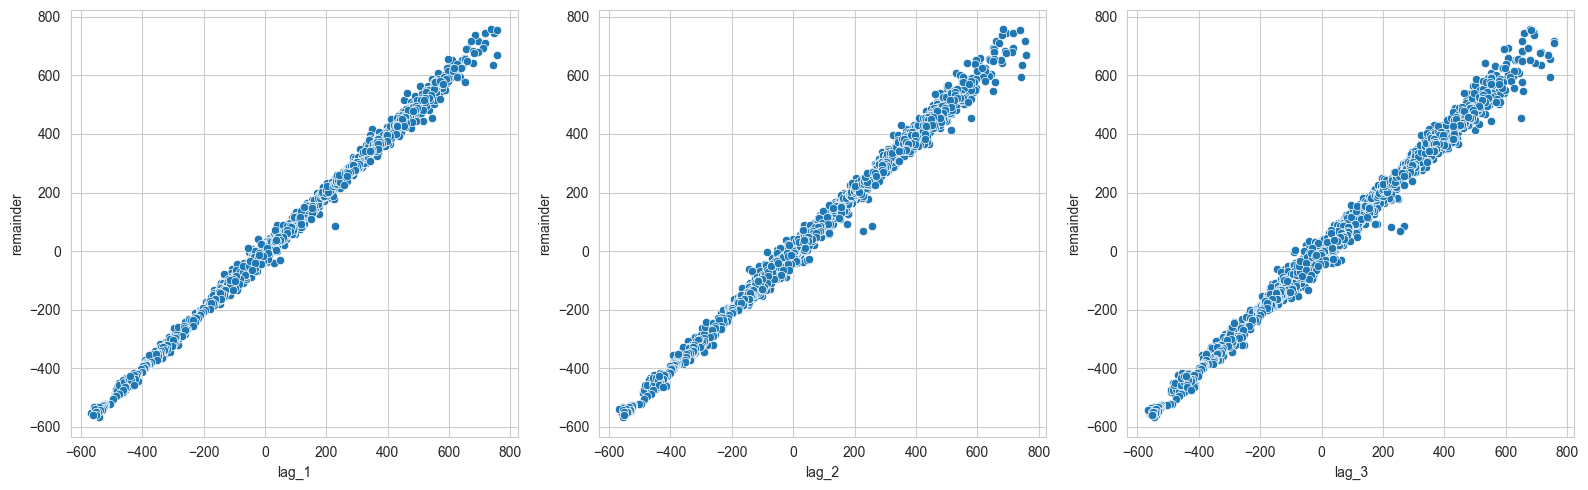

In [80]:
import matplotlib.gridspec as gridspec

lag_columns = df.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(
        x=df[lag_columns[i]],
        y=df['remainder'],
        ax=axes[i]
    )
    
plt.tight_layout()

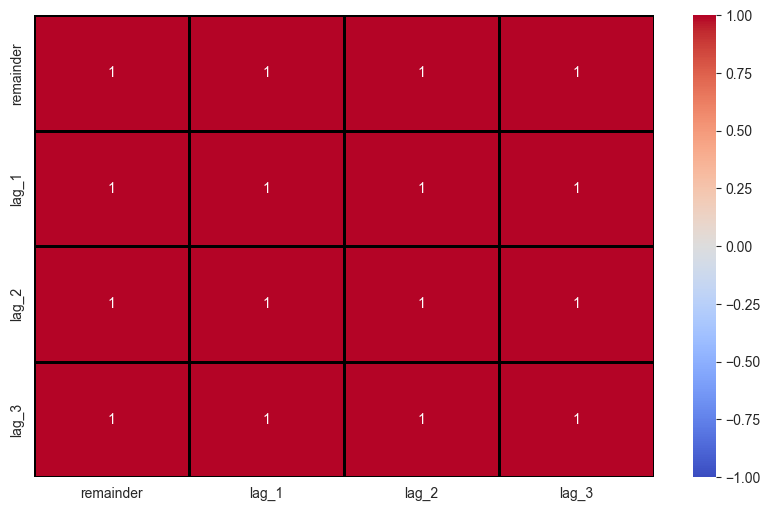

In [81]:
plt.rcParams['figure.figsize'] = (10,6)
sns.heatmap(round(df.corr(),2), 
            cmap = "coolwarm",
            linecolor='black', 
            linewidth=1, 
            annot=True,
            vmin=-1, 
            vmax=1
           );

In [82]:
df.dropna(inplace=True)
df.head()

,remainder,lag_1,lag_2,lag_3
Date,,,,
1985-01-10,-234.665160,-238.175713,-236.886352,-240.847076
1985-01-11,-234.004693,-234.665160,-238.175713,-236.886352
1985-01-14,-239.044311,-234.004693,-234.665160,-238.175713
1985-01-15,-236.034016,-239.044311,-234.004693,-234.665160
1985-01-16,-234.923806,-236.034016,-239.044311,-234.004693


In [83]:
X_remainder = df.drop('remainder',axis=1)
y_remainder = df['remainder']

In [84]:
ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [85]:
df['ar_predictions'] = ar_model.predict(X_remainder)

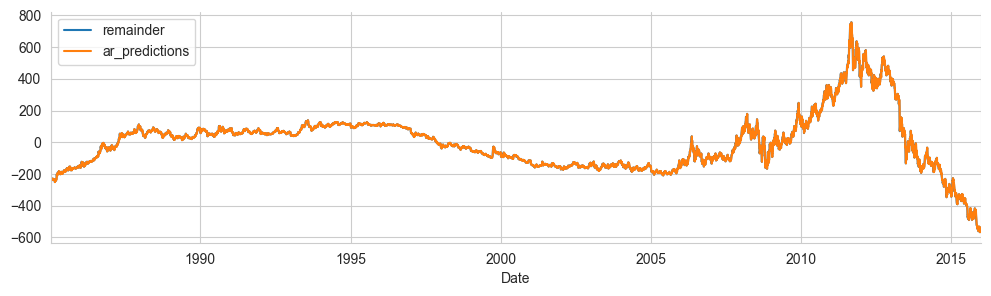

In [86]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df[['remainder','ar_predictions']].plot(legend=True)
sns.despine()

In [87]:
!pip install statsmodels

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

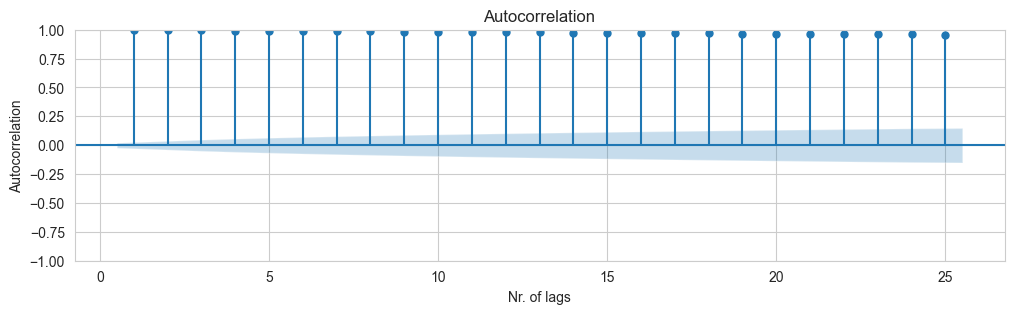

In [89]:
plt.rcParams["figure.dpi"] = 100
plot_acf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

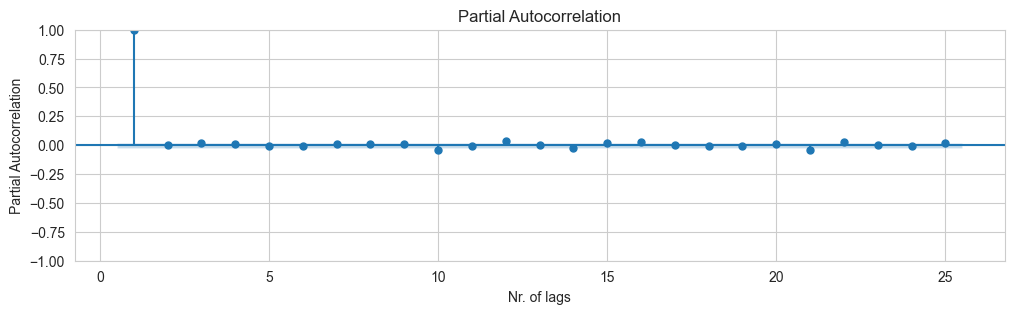

In [90]:
plot_pacf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

In [91]:
df['residuals_ar'] = df['remainder'] - df['ar_predictions']

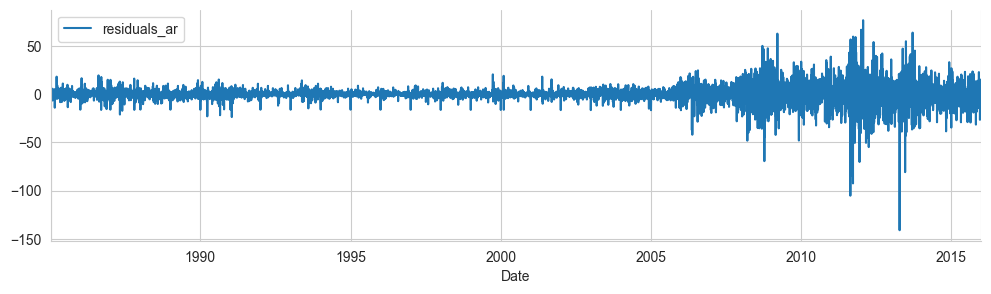

In [92]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df['residuals_ar'].plot(legend=True)
sns.despine()

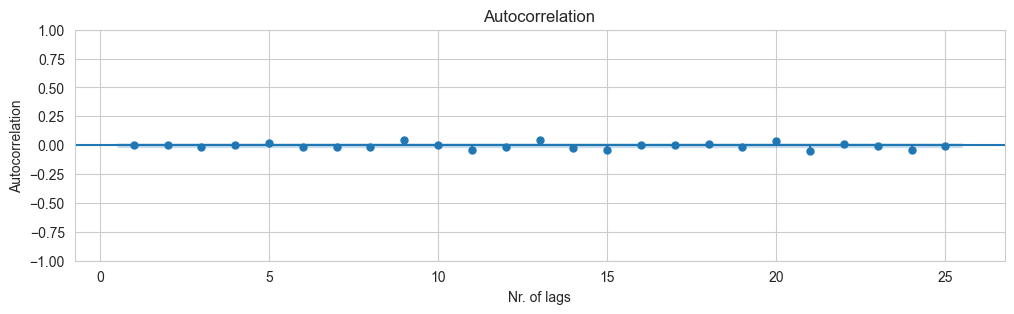

In [93]:
plot_acf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

In [94]:
df['timestep'] = list(range(df.shape[0]))

In [95]:
df.tail()

,remainder,lag_1,lag_2,lag_3,ar_predictions,residuals_ar,timestep
Date,,,,,,,
2015-12-25,-550.810367,-550.328252,-549.846223,-542.714281,-549.891168,-0.919198,8076
2015-12-28,-551.292567,-550.810367,-550.328252,-549.846223,-550.498792,-0.793775,8077
2015-12-29,-549.924853,-551.292567,-550.810367,-550.328252,-550.980692,1.055839,8078
2015-12-30,-560.507224,-549.924853,-551.292567,-550.810367,-549.627528,-10.879696,8079
2015-12-31,-560.989682,-560.507224,-549.924853,-551.292567,-560.149819,-0.839863,8080


In [96]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)

In [97]:
col_transformer = ColumnTransformer([
    ('poly', PolynomialFeatures(degree=2), ['timestep']),
    ('ohe', OneHotEncoder(drop='first'), ['month'])
])

In [98]:
baseline_model = make_pipeline(
    col_transformer,
    LinearRegression()
)

In [99]:
train['timestep'] = train.index.month
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend,detrended,month,seasonality,trend_seasonal,remainder,timestep
Date,,,,,,,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,1985,0,530.237229,-231.987229,1,8.859847,539.097076,-240.847076,1
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504,-228.026504,1,8.859847,538.886352,-236.886352,1
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866,-229.315866,1,8.859847,538.675713,-238.175713,1
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313,-225.805313,1,8.859847,538.465160,-234.665160,1
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846,-225.144846,1,8.859847,538.254693,-234.004693,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099,-558.267099,12,-7.456732,1619.060367,-550.810367,12
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299,-558.749299,12,-7.456732,1619.542567,-551.292567,12
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585,-557.381585,12,-7.456732,1620.024853,-549.924853,12


In [100]:
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend,detrended,month,seasonality,trend_seasonal,remainder,timestep
Date,,,,,,,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,1985,0,530.237229,-231.987229,1,8.859847,539.097076,-240.847076,1
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504,-228.026504,1,8.859847,538.886352,-236.886352,1
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866,-229.315866,1,8.859847,538.675713,-238.175713,1
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313,-225.805313,1,8.859847,538.465160,-234.665160,1
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846,-225.144846,1,8.859847,538.254693,-234.004693,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099,-558.267099,12,-7.456732,1619.060367,-550.810367,12
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299,-558.749299,12,-7.456732,1619.542567,-551.292567,12
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585,-557.381585,12,-7.456732,1620.024853,-549.924853,12


In [101]:
X_train_baseline = train[['timestep','month']]
y_train = train['USD']

In [102]:
baseline_model.fit(X_train_baseline, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('poly', PolynomialFeatures(),
                                                  ['timestep']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['month'])])),
                ('linearregression', LinearRegression())])

In [103]:
train['trend_seasonal'] = baseline_model.predict(X_train_baseline)

In [104]:
train[['USD','trend_seasonal']].tail()

,USD,trend_seasonal
Date,,
2015-12-25,1068.25,623.26559
2015-12-28,1068.25,623.26559
2015-12-29,1070.10,623.26559
2015-12-30,1060.00,623.26559
2015-12-31,1060.00,623.26559


In [105]:
train['remainder'] = train['USD'] - train['trend_seasonal']

In [106]:
def create_lagged_features(df, number_of_lags):
    """"""
    df = df.copy()
    
    lags = list(range(1, number_of_lags+1))
    
    for lag in lags:
        column_name = 'lag_' + str(lag)
        df[column_name] = df['remainder'].shift(lag)
        
    return df

In [107]:
p = 1

In [108]:
train = create_lagged_features(train, number_of_lags=p)

In [109]:
train[train.columns[-p-1:]].head()

,timestep,lag_1
Date,,
1985-01-07,1,NaN
1985-01-08,1,-307.807354
1985-01-09,1,-304.057354
1985-01-10,1,-305.557354
1985-01-11,1,-302.257354


In [110]:
train.dropna(inplace=True)

In [111]:
X_remainder = train[train.columns[-p:]]
y_remainder = train['remainder']

In [112]:
ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [113]:
train['remainder_pred'] = ar_model.predict(X_remainder)

In [114]:
train['total_pred'] = \
train['trend_seasonal'] + train['remainder_pred']

In [115]:
train[['USD','trend_seasonal','total_pred']].tail()

,USD,trend_seasonal,total_pred
Date,,,
2015-12-25,1068.25,623.26559,1068.263929
2015-12-28,1068.25,623.26559,1068.263929
2015-12-29,1070.10,623.26559,1068.263929
2015-12-30,1060.00,623.26559,1070.113604
2015-12-31,1060.00,623.26559,1060.015379


In [116]:
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend,detrended,month,seasonality,trend_seasonal,remainder,timestep,lag_1,remainder_pred,total_pred
Date,,,,,,,,,,,,,,,,,,
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504,-228.026504,1,8.859847,606.057354,-304.057354,1,-307.807354,-307.661177,298.396177
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866,-229.315866,1,8.859847,606.057354,-305.557354,1,-304.057354,-303.911836,302.145518
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313,-225.805313,1,8.859847,606.057354,-302.257354,1,-305.557354,-305.411572,300.645782
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846,-225.144846,1,8.859847,606.057354,-301.807354,1,-302.257354,-302.112152,303.945202
1985-01-14,299.00,395.39,269.13,3790.08,1109.51,859.68,1985,5,529.184464,-230.184464,1,8.859847,606.057354,-307.057354,1,-301.807354,-301.662231,304.395123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099,-558.267099,12,-7.456732,623.265590,444.984410,12,444.984410,444.998339,1068.263929
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299,-558.749299,12,-7.456732,623.265590,444.984410,12,444.984410,444.998339,1068.263929
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585,-557.381585,12,-7.456732,623.265590,446.834410,12,444.984410,444.998339,1068.263929


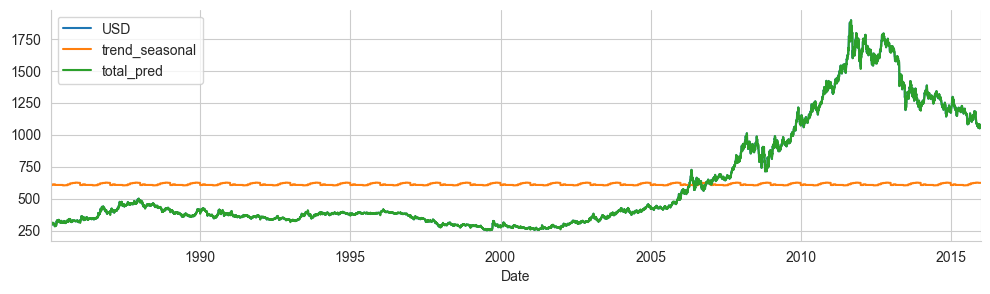

In [117]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train[['USD','trend_seasonal','total_pred']].plot(legend=True)
sns.despine()

In [118]:
r2_ts = round(baseline_model.score(X_train_baseline,y_train),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.000327
